# Fraud Detection - Feature Engineering

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

## Load Train, Test, Val Datasets

In [2]:
def apply_feature_engineering(df):
    df = df.copy()
    
    ## Amount features
    df["amount_per_velocity"] = df["amount"] / (df["velocity_score"] + 1)
    df["amount_log"] = np.log1p(df["amount"])
    df["amount_to_avg_ratio"] = df["amount"] / df.groupby("sender_account")["amount"].transform("mean")
    
    ## Frequency features
    df["transaction_per_day"] = df.groupby(["sender_account","day"])["amount"].transform("count")
    df["transaction_gap"] = df.groupby("sender_account")["timestamp"].diff().dt.total_seconds().fillna(0)
    
    ## Risk features
    df["is_night_transaction"] = df["hour"].between(18,24).astype(int)
    df["is_weekend"] = df["day_of_week"].isin([6,7]).astype(int)
    df["is_self_transfer"] = (df["sender_account"] == df["receiver_account"]).astype(int)
    
    ## Network features
    df["sender_degree"] = df.groupby("sender_account")["receiver_account"].transform("nunique")
    df["receiver_degree"] = df.groupby("receiver_account")["sender_account"].transform("nunique")
    df["sender_total_transaction"] = df.groupby("sender_account")["amount"].transform("count")
    df["receiver_total_transaction"] = df.groupby("receiver_account")["amount"].transform("count")
    
    ## Aggregation features
    df["sender_avg_amount"] = df.groupby("sender_account")["amount"].transform("mean")
    df["sender_std_amount"] = df.groupby("sender_account")["amount"].transform("std").fillna(0)
    
    ## Fraud features
    df["sender_fraud_transaction"] = df.groupby("sender_account")["is_fraud"].transform("sum")
    df["receiver_fraud_transaction"] = df.groupby("receiver_account")["is_fraud"].transform("sum")
    df["sender_fraud_percentage"] = (df["sender_fraud_transaction"]*100/df["sender_total_transaction"]).round(2)
    df["receiver_fraud_percentage"] = (df["receiver_fraud_transaction"]*100/df["receiver_total_transaction"]).round(2)
    df[["sender_fraud_percentage", "receiver_fraud_percentage"]] = df[["sender_fraud_percentage", "receiver_fraud_percentage"]].fillna(0)
    
    ## Other features
    df["deviation_squared"] = df["spending_deviation_score"] ** 2
    
    ## Clean up unnecessary columns
    columns_to_drop = ['Unnamed: 0', 'timestamp']
    df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)
    
    # Drop any rows with missing values in critical columns
    df.dropna(subset=['hour', 'day', 'day_of_week', 'month'], inplace=True)
    
    return df

In [3]:
# Load train, test, and validation datasets
train_df = pd.read_csv("../DATA/processed/train.csv")
test_df = pd.read_csv("../DATA/processed/test.csv")
val_df = pd.read_csv("../DATA/processed/val.csv")

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"Val shape: {val_df.shape}")
print("\nTrain data preview:")
train_df.head()

Train shape: (3733016, 20)
Test shape: (842075, 20)
Val shape: (424906, 20)

Train data preview:


,timestamp,sender_account,receiver_account,amount,transaction_type,merchant_category,location,device_used,is_fraud,time_since_last_transaction,spending_deviation_score,velocity_score,geo_anomaly_score,payment_channel,ip_address,device_hash,hour,day,day_of_week,month
0,2023-01-01 00:09:26.241974,158871,89037,12.25,2,1,1,0,0,-7559.966086,-0.32,2.0,0.96,1,4781010,3735305,0.0,1.0,6.0,1.0
1,2023-01-01 00:11:36.452582,376957,4992,1347.27,0,6,5,1,0,1.525799,-0.68,5.0,0.67,1,232516,550645,0.0,1.0,6.0,1.0
2,2023-01-01 00:12:48.028557,727819,491398,20.79,1,6,6,3,0,-4568.663237,0.14,8.0,0.42,3,2541431,3740925,0.0,1.0,6.0,1.0
3,2023-01-01 00:21:19.560899,545869,270273,740.73,0,7,0,1,0,1.525799,-2.09,20.0,0.86,1,609531,1437485,0.0,1.0,6.0,1.0
4,2023-01-01 00:23:15.259766,880977,66830,228.67,0,1,1,1,0,-48.738700,0.16,18.0,0.82,1,736628,1085200,0.0,1.0,6.0,1.0


In [4]:
# Convert timestamp to datetime for all datasets
train_df["timestamp"] = pd.to_datetime(train_df["timestamp"])
test_df["timestamp"] = pd.to_datetime(test_df["timestamp"])
val_df["timestamp"] = pd.to_datetime(val_df["timestamp"])

In [5]:
# Apply feature engineering to all datasets
print("Applying feature engineering to train set...")
train_engineered = apply_feature_engineering(train_df)
print(f"Train engineered shape: {train_engineered.shape}")

Applying feature engineering to train set...
Train engineered shape: (3733016, 38)


In [6]:
print("\nApplying feature engineering to test set...")
test_engineered = apply_feature_engineering(test_df)
print(f"Test engineered shape: {test_engineered.shape}")


Applying feature engineering to test set...
Test engineered shape: (842075, 38)


In [7]:
print("\nApplying feature engineering to validation set...")
val_engineered = apply_feature_engineering(val_df)
print(f"Val engineered shape: {val_engineered.shape}")


Applying feature engineering to validation set...
Val engineered shape: (424906, 38)


## Correlation Analysis

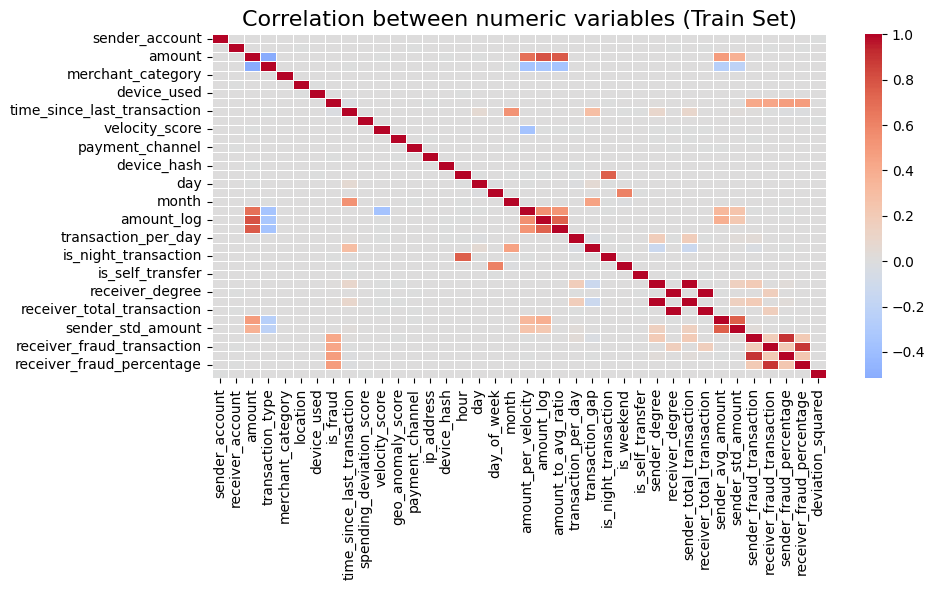

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Correlation matrix
correlation_matrix = train_engineered.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, linewidths=0.5, cbar=True)
plt.title("Correlation between numeric variables (Train Set)", fontsize=16)
plt.tight_layout()
plt.show()

In [9]:
# Display statistics
train_engineered.describe()

,sender_account,receiver_account,amount,transaction_type,merchant_category,location,device_used,is_fraud,time_since_last_transaction,spending_deviation_score,...,receiver_degree,sender_total_transaction,receiver_total_transaction,sender_avg_amount,sender_std_amount,sender_fraud_transaction,receiver_fraud_transaction,sender_fraud_percentage,receiver_fraud_percentage,deviation_squared
count,3.733016e+06,3.733016e+06,3.733016e+06,3.733016e+06,3.733016e+06,3.733016e+06,3.733016e+06,3.733016e+06,3.733016e+06,3.733016e+06,...,3.733016e+06,3.733016e+06,3.733016e+06,3.733016e+06,3.733016e+06,3.733016e+06,3.733016e+06,3.733016e+06,3.733016e+06,3.733016e+06
mean,4.483378e+05,4.483195e+05,3.588624e+02,1.499421e+00,3.501209e+00,3.500274e+00,1.500029e+00,3.587046e-02,-9.094015e+02,-2.974994e-04,...,5.146223e+00,5.148478e+00,5.146237e+00,3.588624e+02,3.975002e+02,1.903873e-01,1.845291e-01,3.587175e+00,3.587167e+00,1.001859e+00
std,2.588119e+05,2.587374e+05,4.698450e+02,1.117843e+00,2.291008e+00,2.291124e+00,1.118033e+00,1.859671e-01,2.890842e+03,1.000929e+00,...,2.035380e+00,2.039044e+00,2.035385e+00,2.287731e+02,2.435942e+02,4.362297e-01,4.276476e-01,8.811629e+00,9.051093e+00,1.418680e+00
min,0.000000e+00,0.000000e+00,1.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-8.777814e+03,-5.260000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.242510e+05,2.242080e+05,2.656000e+01,0.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,0.000000e+00,-2.849227e+03,-6.800000e-01,...,4.000000e+00,4.000000e+00,4.000000e+00,1.873400e+02,1.977862e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.024000e-01
50%,4.482415e+05,4.484370e+05,1.386500e+02,1.000000e+00,4.000000e+00,4.000000e+00,1.000000e+00,0.000000e+00,-1.514962e+02,-0.000000e+00,...,5.000000e+00,5.000000e+00,5.000000e+00,3.274886e+02,3.878838e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.489000e-01
75%,6.726600e+05,6.722510e+05,5.039500e+02,2.000000e+00,6.000000e+00,5.000000e+00,3.000000e+00,0.000000e+00,6.309321e+02,6.700000e-01,...,6.000000e+00,6.000000e+00,6.000000e+00,4.884692e+02,5.694149e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.322500e+00
max,8.965120e+05,8.966380e+05,3.419970e+03,3.000000e+00,7.000000e+00,7.000000e+00,3.000000e+00,1.000000e+00,6.548862e+03,4.850000e+00,...,1.700000e+01,1.800000e+01,1.700000e+01,3.141290e+03,2.136848e+03,5.000000e+00,4.000000e+00,1.000000e+02,1.000000e+02,2.766760e+01


In [10]:
# Display sample of engineered features (train set)
print("Sample of engineered features from train set:")
train_engineered.head(10)

Sample of engineered features from train set:


,sender_account,receiver_account,amount,transaction_type,merchant_category,location,device_used,is_fraud,time_since_last_transaction,spending_deviation_score,...,receiver_degree,sender_total_transaction,receiver_total_transaction,sender_avg_amount,sender_std_amount,sender_fraud_transaction,receiver_fraud_transaction,sender_fraud_percentage,receiver_fraud_percentage,deviation_squared
0,158871,89037,12.25,2,1,1,0,0,-7559.966086,-0.32,...,4,5,4,225.752000,194.592575,0,0,0.0,0.00,0.1024
1,376957,4992,1347.27,0,6,5,1,0,1.525799,-0.68,...,4,9,4,432.798889,503.598960,0,0,0.0,0.00,0.4624
2,727819,491398,20.79,1,6,6,3,0,-4568.663237,0.14,...,6,5,6,170.508000,189.434766,0,1,0.0,16.67,0.0196
3,545869,270273,740.73,0,7,0,1,0,1.525799,-2.09,...,4,5,4,445.014000,413.808428,0,0,0.0,0.00,4.3681
4,880977,66830,228.67,0,1,1,1,0,-48.738700,0.16,...,6,5,6,661.024000,649.946021,0,0,0.0,0.00,0.0256
5,892085,284721,1647.18,0,5,3,0,0,-3791.283444,1.01,...,6,4,6,825.067500,719.715907,0,0,0.0,0.00,1.0201
6,516258,30107,10.26,2,7,7,2,0,1.525799,-0.19,...,5,1,5,10.260000,0.000000,0,0,0.0,0.00,0.0361
7,552505,676226,1626.52,0,1,0,0,0,-7478.288218,-0.63,...,4,5,4,723.444000,818.153893,0,0,0.0,0.00,0.3969
8,186345,633891,2107.20,0,5,0,3,0,-2816.832554,-0.03,...,5,8,5,1163.758750,692.818841,0,0,0.0,0.00,0.0009
9,453962,378964,6.65,1,2,6,1,0,-1373.455542,-0.25,...,1,8,1,239.592500,402.375534,0,0,0.0,0.00,0.0625


## Feature Summary and Validation

In [11]:
# Check for missing values
print("Missing values in train set:", train_engineered.isna().sum().sum())
print("Missing values in test set:", test_engineered.isna().sum().sum())
print("Missing values in validation set:", val_engineered.isna().sum().sum())

Missing values in train set: 0
Missing values in test set: 0
Missing values in validation set: 0


In [12]:
print("Feature names in engineered datasets:")
print(f"Total features: {len(train_engineered.columns)}")
print("\nFeature list:")
for i, col in enumerate(train_engineered.columns, 1):
    print(f"{i:2d}. {col}")

Feature names in engineered datasets:
Total features: 38

Feature list:
 1. sender_account
 2. receiver_account
 3. amount
 4. transaction_type
 5. merchant_category
 6. location
 7. device_used
 8. is_fraud
 9. time_since_last_transaction
10. spending_deviation_score
11. velocity_score
12. geo_anomaly_score
13. payment_channel
14. ip_address
15. device_hash
16. hour
17. day
18. day_of_week
19. month
20. amount_per_velocity
21. amount_log
22. amount_to_avg_ratio
23. transaction_per_day
24. transaction_gap
25. is_night_transaction
26. is_weekend
27. is_self_transfer
28. sender_degree
29. receiver_degree
30. sender_total_transaction
31. receiver_total_transaction
32. sender_avg_amount
33. sender_std_amount
34. sender_fraud_transaction
35. receiver_fraud_transaction
36. sender_fraud_percentage
37. receiver_fraud_percentage
38. deviation_squared


## Save Feature-Engineered Data

In [14]:
import os 

os.makedirs("../DATA/feature_engineered/", exist_ok=True)

# Save the feature-engineered datasets
train_output = "../DATA/feature_engineered/train.csv"
test_output = "../DATA/feature_engineered/test.csv"
val_output = "../DATA/feature_engineered/val.csv"

train_engineered.to_csv(train_output, index=False)
test_engineered.to_csv(test_output, index=False)
val_engineered.to_csv(val_output, index=False)

print(f"Train data saved to: {train_output} | Shape: {train_engineered.shape}")
print(f"Test data saved to: {test_output} | Shape: {test_engineered.shape}")
print(f"Val data saved to: {val_output} | Shape: {val_engineered.shape}")

Train data saved to: ../DATA/feature_engineered/train.csv | Shape: (3733016, 38)
Test data saved to: ../DATA/feature_engineered/test.csv | Shape: (842075, 38)
Val data saved to: ../DATA/feature_engineered/val.csv | Shape: (424906, 38)
